![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 06. <i>Rozpoznawanie i segmentacja obrazów</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

W poniższych materiałach zobaczymy w jaki sposób możemy klasycznym podejściem rozpoznawać ludzi na zdjęciach, a ponadto w jaki sposób szybko podzielić obraz na elementy znajdujące się na pierwszym planie i w tle obrazu.

Na początku załadujmy niezbędne biblioteki.

In [7]:
import cv2 as cv
import numpy as np
import sklearn.svm
import sklearn.metrics
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random

Naszym głównym celem będzie rozpoznawanie ludzi na zdjęciach przy pomocy klasycznej metody *histogram of oriented gradients* (HOG). Krótko mówiąc, dla danego zdjęcia chcemy uzyskać wektor cech, który będziemy mogli wykorzystać w klasyfikatorze SVM. Szczegóły znajdują się w *6.3.2 Pedestrian detection* R. Szeliski (2022) *Computer Vision: Algorithms and Applications*, natomiast tutaj zobrazujemy techniczne wykorzystanie tej metody.

# Klasyfikacja obrazów przy użyciu HOG i SVM

Spróbjemy zbudować klasyfikator, który wskazuje czy na zdjęciu znajduje się osoba z okularami czy bez okularów. Rozpakujmy zbiór danych, z którego będziemy korzystali:

In [8]:
!cd datasets && unzip -qo glasses.zip

Następnie wczytujemy dane i dzielimy je na dwa zbiory w proporcjach 80/20:

In [9]:
dataset_dir = "datasets/glasses"
images_0 = os.listdir(f"{dataset_dir}/with")
images_0 = [f"{dataset_dir}/with/{x}" for x in images_0]
images_1 = os.listdir(f"{dataset_dir}/without")
images_1 = [f"{dataset_dir}/without/{x}" for x in images_1]
images = images_0 + images_1
random.seed(1337)
random.shuffle(images)

train_data = []
test_data = []
train_labels = []
test_labels = []

splitval = int((1-0.2)*len(images))

for x in images[:splitval]:
    train_data.append(cv.imread(x, cv.IMREAD_COLOR))
    train_labels.append(x.split("/")[2])
    
for x in images[splitval:]:
    test_data.append(cv.imread(x, cv.IMREAD_COLOR))
    test_labels.append(x.split("/")[2])
    
d_labels = {"with": 0, "without": 1}
    
train_labels = np.array([d_labels[x] for x in train_labels])
test_labels = np.array([d_labels[x] for x in test_labels])

print(f"Train data: {len(train_data)}, test data: {len(test_data)}")

Train data: 1272, test data: 319


Poniżej znajduje się kilka przykładowych zdjęć.

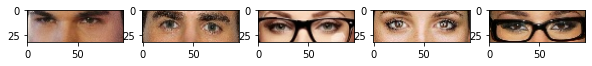

In [10]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(151 + i)
    plt.imshow(train_data[i][:,:,::-1]);

Tworzymy deskryptor HOG przy pomocy funkcji [`cv.HOGDescriptor()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html). Metodą [`compute()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html#a38cd712cd5a6d9ed0344731fcd121e8b) tworzymy wektory cech, które posłużą nam jako dane wejściowe do klasyfikatora. Poniżej znajduje się również przykładowa konfiguracja deskryptora:

In [11]:
hp_win_size = (96, 32)
hp_block_size = (8, 8)
hp_block_stride = (8, 8)
hp_cell_size = (4, 4)
hp_n_bins = 9
hp_deriv_aperture = 0
hp_win_sigma = 4.0
hp_histogram_norm_type = 1
hp_l2_hys_threshold = 0.2
hp_gamma_correction = True
hp_n_levels = 64
hp_signed_gradient = True

hog_descriptor = cv.HOGDescriptor(
    hp_win_size, hp_block_size, hp_block_stride, hp_cell_size, 
    hp_n_bins, hp_deriv_aperture, hp_win_sigma, 
    hp_histogram_norm_type, hp_l2_hys_threshold, 
    hp_gamma_correction, hp_n_levels, hp_signed_gradient)

train_hog = np.vstack([hog_descriptor.compute(x).ravel() for x in train_data])
test_hog = np.vstack([hog_descriptor.compute(x).ravel() for x in test_data])

Do klasyfikacji użyjemy klasyfikatora SVM. Możemy użyć implementacji znajdującej się w module [`cv.ml`](https://docs.opencv.org/4.5.3/d1/d2d/classcv_1_1ml_1_1SVM.html):

In [12]:
model = cv.ml.SVM_create()
model.setGamma(0.02)
model.setC(2.5)
model.setKernel(cv.ml.SVM_RBF)
model.setType(cv.ml.SVM_C_SVC)

Trenujemy model:

In [13]:
model.train(np.array(train_hog), cv.ml.ROW_SAMPLE, train_labels);

Sprawdzamy wynik na danych testowych:

In [14]:
predictions = model.predict(test_hog)[1].ravel()
accuracy = (test_labels == predictions).mean()
print(f"ACC: {accuracy * 100:.2f} %")

ACC: 95.61 %


Możemy również użyć implementacji klasyfikatora znajdującej się w bibliotece [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html):

In [15]:
model = sklearn.svm.SVC(C=2.5, gamma=0.02, kernel='rbf')
model.fit(train_hog, train_labels)

predictions = model.predict(test_hog)
accuracy = (test_labels == predictions).mean()
print(f"ACC: {accuracy * 100:.2f} %")

ACC: 95.61 %


# Rozpoznawanie ludzi

Powyższą metodykę klasyfikcji możemy zastosować do rozpoznawania obiektów na zdjęciach, np. ludzi. W tym wypadku będziemy chcieli wskazać gdzie na zdjęciu znajduje się dany obiekt lub obiekty.

Rozpocznijmy od rozpakowania zbioru danych:

In [16]:
!cd datasets && unzip -qo inria-person-sub.zip

Wczytujemy dane, które są już podzielone na dwa zbiory:

In [17]:
dataset_dir = "datasets/INRIAPerson"

images_train_0 = os.listdir(f"{dataset_dir}/train_64x128_H96/negPatches")
images_train_0 = [f"{dataset_dir}/train_64x128_H96/negPatches/{x}" for x in images_train_0]
images_train_1 = os.listdir(f"{dataset_dir}/train_64x128_H96/posPatches")
images_train_1 = [f"{dataset_dir}/train_64x128_H96/posPatches/{x}" for x in images_train_1]

images_test_0 = os.listdir(f"{dataset_dir}/test_64x128_H96/negPatches")
images_test_0 = [f"{dataset_dir}/test_64x128_H96/negPatches/{x}" for x in images_test_0]
images_test_1 = os.listdir(f"{dataset_dir}/test_64x128_H96/posPatches")
images_test_1 = [f"{dataset_dir}/test_64x128_H96/posPatches/{x}" for x in images_test_1]

train_data = []
test_data = []
train_labels = []
test_labels = []

for x in images_train_0:
    img = cv.imread(x, cv.IMREAD_COLOR)
    if img is not None:
        train_data.append(img)
        train_labels.append(0)

for x in images_train_1:
    img = cv.imread(x, cv.IMREAD_COLOR)
    if img is not None:
        train_data.append(img)
        train_labels.append(1)
    
for x in images_test_0:
    img = cv.imread(x, cv.IMREAD_COLOR)
    if img is not None:
        test_data.append(img)
        test_labels.append(0)

for x in images_test_1:
    img = cv.imread(x, cv.IMREAD_COLOR)
    if img is not None:
        test_data.append(img)
        test_labels.append(1)

print(f"Train data: {len(train_data)}, test data: {len(test_data)}")

Train data: 1457, test data: 560


Poniżej znajduje się kilka przykładowych zdjęć ze zbioru:

In [18]:
plt.figure(figsize=(10,2))
for i in range(3):
    plt.subplot(161 + i)
    plt.imshow(train_data[i][:,:,::-1]);
for i in range(3):
    plt.subplot(164 + i)
    plt.imshow(train_data[-(i+1)][:,:,::-1]);

Tworzymy deskryptor i wektory cech:

In [ ]:
hp_win_size = (64, 128)
hp_block_size = (16, 16)
hp_block_stride = (8, 8)
hp_cell_size = (8, 8)
hp_n_bins = 9
hp_deriv_aperture = 1
hp_win_sigma = -1
hp_histogram_norm_type = 0
hp_l2_hys_threshold = 0.2
hp_gamma_correction = True
hp_n_levels = 64
hp_signed_gradient = False

hog_descriptor = cv.HOGDescriptor(
    hp_win_size, hp_block_size, hp_block_stride, hp_cell_size, 
    hp_n_bins, hp_deriv_aperture, hp_win_sigma, 
    hp_histogram_norm_type, hp_l2_hys_threshold, 
    hp_gamma_correction, hp_n_levels, hp_signed_gradient)

train_hog = np.vstack([hog_descriptor.compute(x).ravel() for x in train_data])
test_hog = np.vstack([hog_descriptor.compute(x).ravel() for x in test_data])

Następnie tworzymy klasyfikator:

In [ ]:
model = cv.ml.SVM_create()
model.setGamma(0)
model.setC(0.01)
model.setKernel(cv.ml.SVM_LINEAR)
model.setType(cv.ml.SVM_C_SVC)
model.setTermCriteria((cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 1000, 1e-3))

Uczymy model:

In [ ]:
model.train(np.array(train_hog), cv.ml.ROW_SAMPLE, np.array(train_labels));

Sprawdzamy jakość klasyfikacji:

In [ ]:
predictions = model.predict(test_hog)[1].ravel()
accuracy = (test_labels == predictions).mean()
print(f"ACC: {accuracy * 100:.2f} %")

Poniżej znajduje się podejście przy pomocy biblioteki *scikit-learn*:

In [ ]:
model2 = sklearn.svm.SVC(C=0.01, gamma='auto', kernel='linear', max_iter=1000)
model2.fit(train_hog, train_labels)

predictions = model2.predict(test_hog)
accuracy = (test_labels == predictions).mean()
print(f"Accuracy:  {sklearn.metrics.accuracy_score(test_labels, predictions) * 100:.2f} %")
print(f"Precision: {sklearn.metrics.precision_score(test_labels, predictions) * 100:.2f} %")
print(f"Recall:    {sklearn.metrics.recall_score(test_labels, predictions) * 100:.2f} %")

Mając teraz wyuczony model, chcielibyśmy sprawdzić czy np. na zdjęciu `img/pedestrians.jpg` znajdują się ludzie, tak aby uzyskać ew. obramowania z ich występowaniem. W pierwszej kolejności w naszym deskryptorze HOG ustawiamy współczynniki klasfikatora SVM przy pomocy metody [`setSVMDetector()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html#a6de5ac55631eed51e36278cde3a2c159). Następnie przy pomocy metody [`detectMultiScale()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html#a91e56a2c317392e50fbaa2f5dc78d30b) znajdujemy wyszukiwane obiekty (ludzi) w różnych skalach.

In [ ]:
image = cv.imread("img/pedestrians.jpg", cv.IMREAD_COLOR)
scale = 600 / image.shape[0]
image = cv.resize(image, None, fx=scale, fy=scale)

support_vectors = model.getSupportVectors()
rho, _, _ = model.getDecisionFunction(0)
detector = np.zeros(support_vectors.shape[1] + 1, dtype=support_vectors.dtype)
detector[:-1] = -support_vectors[:]
detector[-1] = rho

hog_descriptor.setSVMDetector(detector)

locations, weights = hog_descriptor.detectMultiScale(
    image, winStride=(8, 8), padding=(32, 32), scale=1.05,
    finalThreshold=2, hitThreshold=1.0)

for location, weight in zip(locations, weights):
    x1, y1, w, h = location
    x2, y2 = x1 + w, y1 + h
    cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), thickness=3, lineType=cv.LINE_AA)
    cv.putText(image, f"{weight[0]:.2f}", (x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv.LINE_AA)

plt.figure(figsize=(6,6))
plt.imshow(image[:,:,::-1]);

Coś nam nawet udało się wykryć jak na tak niewielki zbiór danych uczących ;) Z drugiej strony, dwie osoby na pierwszym planie zostały pominięte, a osoba po prawej jest dyskusyjna jeśli chodzi o zakres oznaczenia.

W OpenCV dostępny jest domyślny klasyfikator w funkcji [`HOGDescriptor_getDefaultPeopleDetector()`](https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html#a9c7a0b2aa72cf39b4b32b3eddea78203) i poniżej możemy zobaczyć jak sobie radzi na badanym zdjęciu:

In [ ]:
image = cv.imread("img/pedestrians.jpg", cv.IMREAD_COLOR)
scale = 600 / image.shape[0]
image = cv.resize(image, None, fx=scale, fy=scale)

hog_dflt_descriptor = cv.HOGDescriptor(
    hp_win_size, hp_block_size, hp_block_stride, hp_cell_size, 
    hp_n_bins, hp_deriv_aperture, hp_win_sigma, 
    hp_histogram_norm_type, hp_l2_hys_threshold, 
    hp_gamma_correction, hp_n_levels, hp_signed_gradient)

detector_dflt = cv.HOGDescriptor_getDefaultPeopleDetector()
hog_dflt_descriptor.setSVMDetector(detector_dflt)

locations, weights = hog_dflt_descriptor.detectMultiScale(
    image, winStride=(8, 8), padding=(32, 32), scale=1.05,
    finalThreshold=2, hitThreshold=1.0)

for location, weight in zip(locations, weights):
    x1, y1, w, h = location
    x2, y2 = x1 + w, y1 + h
    cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), thickness=3, lineType=cv.LINE_AA)
    cv.putText(image, f"{weight[0]:.2f}", (x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv.LINE_AA)

plt.figure(figsize=(6,6))
plt.imshow(image[:,:,::-1]);

# Segmentacja obrazu metodą GrabCut

## Zadanie 1

W poniższym zadaniu użyjemy algorytmu [GrabCut](https://en.wikipedia.org/wiki/GrabCut), będącego interaktywną metodą segmentacji obrazu, dzielącą obraz na pierwszy i drugi plan. W OpenCV algorytm jest zaimplementowany w funkcji [`cv.grabCut()`](https://docs.opencv.org/4.5.3/d3/d47/group__imgproc__segmentation.html#ga909c1dda50efcbeaa3ce126be862b37f). Dodatkowe informacje o algorytmie znajdują się w [dokumentacji](https://docs.opencv.org/4.5.3/d8/d83/tutorial_py_grabcut.html).

Przygotuj interaktywną aplikację, która wykorzystuje algorytm GrabCut. W aplikacji powinna być możliwość zaznaczenia początkowego prostokąta, a następnie elementy maski (zwróć uwagę z jakich elementów może składać się maska). Przykładowe działanie możesz zaprezentować na obrazie `img/messi5.jpg`.

![GrabCut - wynik](img/grabcut-result.png)

In [3]:
import numpy as np
import cv2
import sys
'''
===============================================================================
Interactive Image Segmentation using GrabCut algorithm.

This application shows interactive image segmentation using grabcut algorithm.

USAGE :
    python grabcut.py <filename>

README FIRST:
    Two windows will show up, one for input and one for output.

    At first, in input window, draw a rectangle around the object using
mouse right button. Then press 'n' to segment the object (once or a few times)
For any finer touch-ups, you can press any of the keys below and draw lines on
the areas you want. Then again press 'n' for updating the output.

Key '0' - To select areas of sure background
Key '1' - To select areas of sure foreground
Key '2' - To select areas of probable background
Key '3' - To select areas of probable foreground

Key 'n' - To update the segmentation
Key 'r' - To reset the setup
Key 's' - To save the results
===============================================================================
'''
BLUE = [255,0,0]        # rectangle color
RED = [0,0,255]         # PR BG
GREEN = [0,255,0]       # PR FG
BLACK = [0,0,0]         # sure BG
WHITE = [255,255,255]   # sure FG

DRAW_BG = {'color' : BLACK, 'val' : 0}
DRAW_FG = {'color' : WHITE, 'val' : 1}
DRAW_PR_FG = {'color' : GREEN, 'val' : 3}
DRAW_PR_BG = {'color' : RED, 'val' : 2}

# setting up flags
rect = (0,0,1,1)
drawing = False         # flag for drawing curves
rectangle = False       # flag for drawing rect
rect_over = False       # flag to check if rect drawn
rect_or_mask = 100      # flag for selecting rect or mask mode
value = DRAW_FG         # drawing initialized to FG
thickness = 3           # brush thickness

def onmouse(event,x,y,flags,param):
    global img,img2,drawing,value,mask,rectangle,rect,rect_or_mask,ix,iy,rect_over




    if event == cv2.EVENT_RBUTTONDOWN:
        rectangle = True
        ix,iy = x,y

    elif event == cv2.EVENT_MOUSEMOVE:
        if rectangle == True:
            img = img2.copy()
            cv2.rectangle(img,(ix,iy),(x,y),BLUE,2)
            rect = (ix,iy,abs(ix-x),abs(iy-y))
            rect_or_mask = 0

    elif event == cv2.EVENT_RBUTTONUP:
        rectangle = False
        rect_over = True
        cv2.rectangle(img,(ix,iy),(x,y),BLUE,2)
        rect = (ix,iy,abs(ix-x),abs(iy-y))
        rect_or_mask = 0
        print (" Now press the key 'n' a few times until no further change \n")



    # draw touchup curves
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.circle(img,(x,y),thickness,value['color'],-1)
            cv2.circle(mask,(x,y),thickness,value['val'],-1)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.circle(img,(x,y),thickness,value['color'],-1)
        cv2.circle(mask,(x,y),thickness,value['val'],-1)


img = cv2.imread('img/messi5.jpg')
img2 = img.copy()                               # a copy of original image
mask = np.zeros(img.shape[:2],dtype = np.uint8) # mask initialized to PR_BG
output = np.zeros(img.shape,np.uint8)           # output image to be shown

# input and output windows
cv2.namedWindow('output')
cv2.namedWindow('input')
cv2.setMouseCallback('input', onmouse)
cv2.moveWindow('input',img.shape[1]+10,90)

print (" Instructions : \n")
print (" Draw a rectangle around the object using right mouse button \n")

while(True):

    cv2.imshow('output',output)
    cv2.imshow('input',img)
    k = 0xFF & cv2.waitKey(1)

    # key bindings
    if k == 27:         # esc to exit
        break
    elif k == ord('0'): # BG drawing
        print (" mark background regions with left mouse button \n")
        value = DRAW_BG
    elif k == ord('1'): # FG drawing
        print (" mark foreground regions with left mouse button \n")
        value = DRAW_FG
    elif k == ord('2'): # PR_BG drawing
        value = DRAW_PR_BG
    elif k == ord('3'): # PR_FG drawing
        value = DRAW_PR_FG
    elif k == ord('s'): # save image
        bar = np.zeros((img.shape[0],5,3),np.uint8)
        res = np.hstack((img2,bar,img,bar,output))
        cv2.imwrite('grabcut_output.png',output)
        cv2.imwrite('grabcut_output_combined.png',res)
        print (" Result saved as image \n")
    elif k == ord('r'): # reset everything
        print ("resetting \n")
        rect = (0,0,1,1)
        drawing = False
        rectangle = False
        rect_or_mask = 100
        rect_over = False
        value = DRAW_FG
        img = img2.copy()
        mask = np.zeros(img.shape[:2],dtype = np.uint8) # mask initialized to PR_BG
        output = np.zeros(img.shape,np.uint8)           # output image to be shown
    elif k == ord('n'): # segment the image
        print (""" For finer touchups, mark foreground and background after pressing keys 0-3
        and again press 'n' \n""")
        if (rect_or_mask == 0):         # grabcut with rect
            bgdmodel = np.zeros((1,65),np.float64)
            fgdmodel = np.zeros((1,65),np.float64)
            cv2.grabCut(img2,mask,rect,bgdmodel,fgdmodel,1,cv2.GC_INIT_WITH_RECT)
            rect_or_mask = 1
        elif rect_or_mask == 1:         # grabcut with mask
            bgdmodel = np.zeros((1,65),np.float64)
            fgdmodel = np.zeros((1,65),np.float64)
            cv2.grabCut(img2,mask,rect,bgdmodel8,fgdmodel,1,cv2.GC_INIT_WITH_MASK)

    mask2 = np.where((mask==1) + (mask==3),255,0).astype('uint8')
    output = cv2.bitwise_and(img2,img2,mask=mask2)

cv2.destroyAllWindows()

 Instructions : 

 Draw a rectangle around the object using right mouse button 

 Now press the key 'n' a few times until no further change 

 mark background regions with left mouse button 

 mark foreground regions with left mouse button 

 For finer touchups, mark foreground and background after pressing keys 0-3
        and again press 'n' 

 Result saved as image 

 Result saved as image 

 Result saved as image 

 Result saved as image 

 Result saved as image 

 For finer touchups, mark foreground and background after pressing keys 0-3
        and again press 'n' 



NameError: name 'bgdmodel8' is not defined

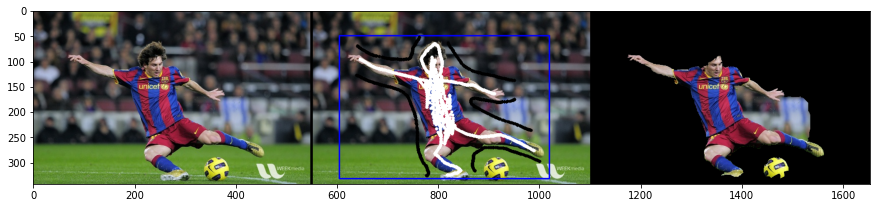

In [4]:
import cv2 as cv
import matplotlib.pyplot as plt
image = cv.imread("grabcut_output_combined.png", cv.IMREAD_COLOR)
plt.figure(figsize=(15,5))
plt.subplot(111)
plt.imshow(image[:,:,::-1])